In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\test.csv', parse_dates=['date'])
sample_sub = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\sample_submission.csv')
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))
train.head()

Train shape:(913000, 4), Test shape:(45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
print("number of unique items :",train.item.nunique())
print("number of unique store :",train.store.nunique())

number of unique items : 50
number of unique store : 10


In [4]:
train['dayofmonth'] = train.date.dt.day
train['dayofyear'] = train.date.dt.dayofyear
train['dayofweek'] = train.date.dt.dayofweek
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['weekofyear'] = train.date.dt.weekofyear
train.head()

,date,store,item,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
0,2013-01-01,1,1,13,1,1,1,1,2013,1
1,2013-01-02,1,1,11,2,2,2,1,2013,1
2,2013-01-03,1,1,14,3,3,3,1,2013,1
3,2013-01-04,1,1,13,4,4,4,1,2013,1
4,2013-01-05,1,1,10,5,5,5,1,2013,1


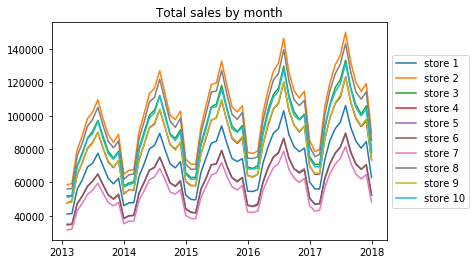

In [5]:
for i in range(1,11):
    month_df = train[train.store==i].resample('M',on='date').sum()
    x= np.array(month_df.index)
    y=np.array(month_df.sales)
    plt.plot(x,y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total sales by month")
plt.show()

Text(0.5, 1.0, 'Store/ Item sales heatmap')

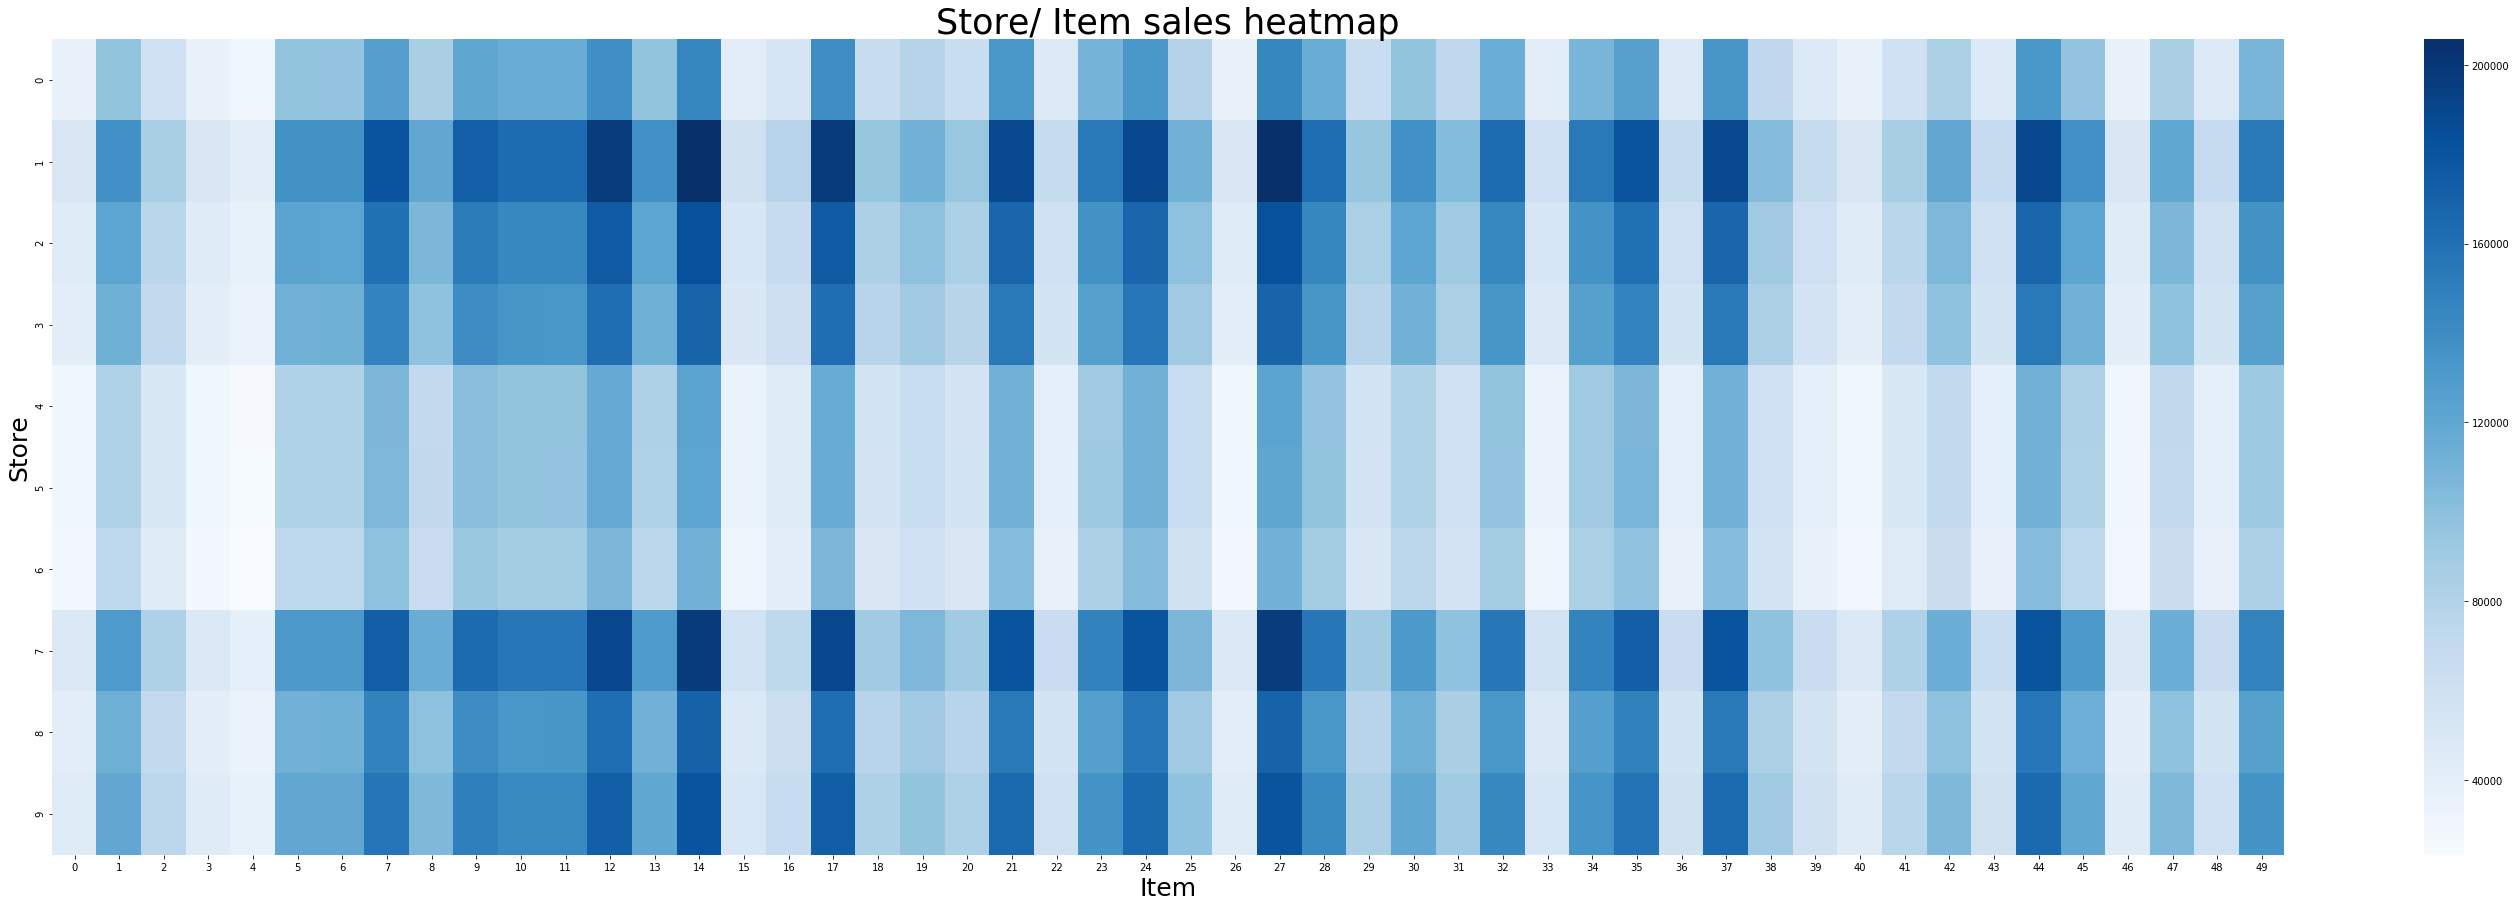

In [6]:
store_item_df = train.groupby(['store','item']).sum()
matrixStoreItem = np.zeros((10,50))
for i in range(1,11):
    for j in range(1,51):
        matrixStoreItem[i-1,j-1] = store_item_df.loc[i,j].sales

plt.figure(figsize=(50,15))
ax = sns.heatmap(matrixStoreItem,cmap='Blues')
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Store",fontsize=25)
plt.title("Store/ Item sales heatmap",fontsize=35)

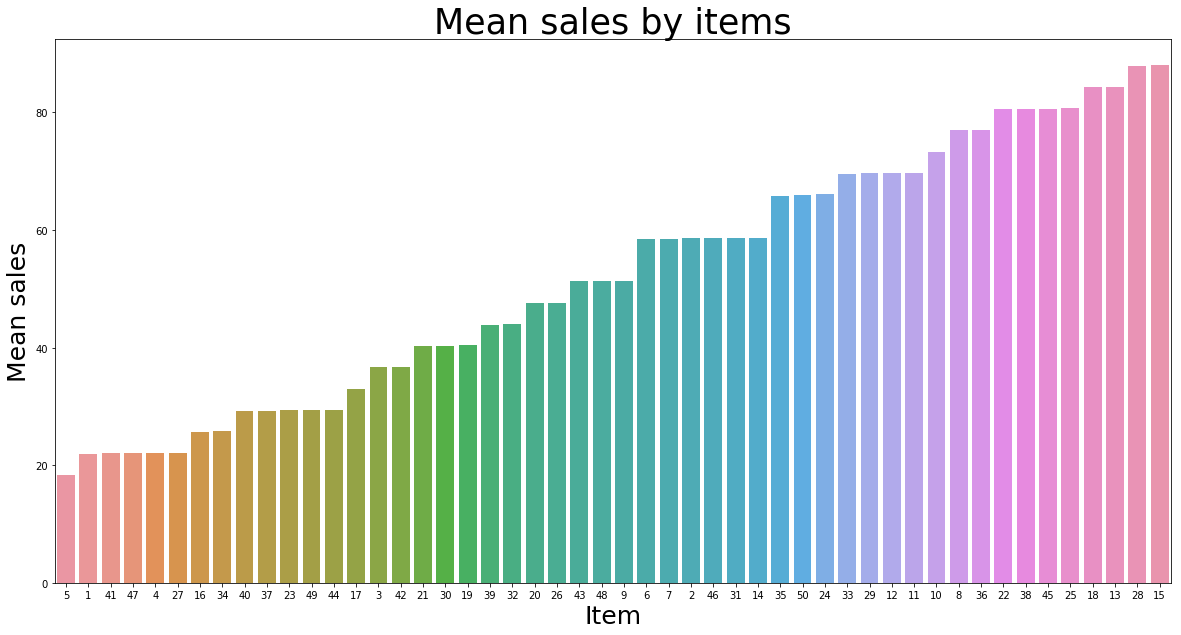

In [7]:
plt.close('all')
item_df = train.groupby(['item']).mean()
item_df.sort_values('sales',ascending=True,inplace=True)
x = item_df.index
y = item_df.sales
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y, order=x)
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Mean sales",fontsize=25)
plt.title("Mean sales by items",fontsize=35)
plt.show()

In [8]:
df = pd.get_dummies(train, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df.head()

,date,sales,dayofyear,year,store_1,store_2,store_3,store_4,store_5,store_6,...,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,weekofyear_53
0,2013-01-01,13,1,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11,2,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14,3,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13,4,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10,5,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]
print("train shape: ",df_train.shape)
print("validation shape :",df_val.shape)

train shape:  (730168, 167)
validation shape : (182832, 167)


In [10]:
df_train.drop('date',axis=1,inplace=True)
df_val.drop('date',axis=1,inplace=True)
y_train = df_train['sales'].values
y_test = df_val['sales'].values
X_train = df_train.drop('sales', axis=1).values
X_test = df_val.drop('sales', axis=1).values

C:\Users\gmjj0\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': {'rmse'}, 'num_leaves': 10, 'learning_rate': 0.05, 
              'feature_fraction': 0.8, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':100, 'nthread':-1}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

C:\Users\gmjj0\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\gmjj0\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 28.5795
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 28.353
[3]	valid_0's rmse: 28.1675
[4]	valid_0's rmse: 27.9546
[5]	valid_0's rmse: 27.7648
[6]	valid_0's rmse: 27.5774
[7]	valid_0's rmse: 27.3803
[8]	valid_0's rmse: 27.2112
[9]	valid_0's rmse: 27.0477
[10]	valid_0's rmse: 26.8767
[11]	valid_0's rmse: 26.7097
[12]	valid_0's rmse: 26.548
[13]	valid_0's rmse: 26.3777
[14]	valid_0's rmse: 26.2052
[15]	valid_0's rmse: 26.0312
[16]	valid_0's rmse: 25.8704
[17]	valid_0's rmse: 25.7109
[18]	valid_0's rmse: 25.5745
[19]	valid_0's rmse: 25.4304
[20]	valid_0's rmse: 25.3019
[21]	valid_0's rmse: 25.1453
[22]	valid_0's rmse: 24.997
[23]	valid_0's rmse: 24.8789
[24]	valid_0's rmse: 24.7319
[25]	valid_0's rmse: 24.5861
[26]	valid_0's rmse: 24.4601
[27]	valid_0's rmse: 24.3261
[28]	valid_0's rmse: 24.1964
[29]	valid_0's rmse: 24.0831
[30]	valid_0's rmse: 23.9565
[31]	valid_0's rmse: 23.8315
[32]	valid_0's rmse: 23.6959
[33]	valid_0's rmse: 

[279]	valid_0's rmse: 11.1237
[280]	valid_0's rmse: 11.106
[281]	valid_0's rmse: 11.0887
[282]	valid_0's rmse: 11.0734
[283]	valid_0's rmse: 11.0575
[284]	valid_0's rmse: 11.0404
[285]	valid_0's rmse: 11.0255
[286]	valid_0's rmse: 11.0102
[287]	valid_0's rmse: 10.994
[288]	valid_0's rmse: 10.9793
[289]	valid_0's rmse: 10.9632
[290]	valid_0's rmse: 10.9477
[291]	valid_0's rmse: 10.9337
[292]	valid_0's rmse: 10.9186
[293]	valid_0's rmse: 10.9028
[294]	valid_0's rmse: 10.8854
[295]	valid_0's rmse: 10.8696
[296]	valid_0's rmse: 10.8562
[297]	valid_0's rmse: 10.8402
[298]	valid_0's rmse: 10.8256
[299]	valid_0's rmse: 10.8126
[300]	valid_0's rmse: 10.799
[301]	valid_0's rmse: 10.7847
[302]	valid_0's rmse: 10.7714
[303]	valid_0's rmse: 10.7582
[304]	valid_0's rmse: 10.7442
[305]	valid_0's rmse: 10.7316
[306]	valid_0's rmse: 10.7189
[307]	valid_0's rmse: 10.7051
[308]	valid_0's rmse: 10.6893
[309]	valid_0's rmse: 10.6756
[310]	valid_0's rmse: 10.6621
[311]	valid_0's rmse: 10.6484
[312]	valid_0

[556]	valid_0's rmse: 9.04275
[557]	valid_0's rmse: 9.03953
[558]	valid_0's rmse: 9.03701
[559]	valid_0's rmse: 9.03401
[560]	valid_0's rmse: 9.03119
[561]	valid_0's rmse: 9.02897
[562]	valid_0's rmse: 9.02617
[563]	valid_0's rmse: 9.02331
[564]	valid_0's rmse: 9.02077
[565]	valid_0's rmse: 9.01852
[566]	valid_0's rmse: 9.01609
[567]	valid_0's rmse: 9.01372
[568]	valid_0's rmse: 9.01169
[569]	valid_0's rmse: 9.00944
[570]	valid_0's rmse: 9.00689
[571]	valid_0's rmse: 9.00433
[572]	valid_0's rmse: 9.00202
[573]	valid_0's rmse: 8.99991
[574]	valid_0's rmse: 8.99724
[575]	valid_0's rmse: 8.99523
[576]	valid_0's rmse: 8.99252
[577]	valid_0's rmse: 8.99059
[578]	valid_0's rmse: 8.98775
[579]	valid_0's rmse: 8.985
[580]	valid_0's rmse: 8.98247
[581]	valid_0's rmse: 8.98007
[582]	valid_0's rmse: 8.9775
[583]	valid_0's rmse: 8.97496
[584]	valid_0's rmse: 8.97216
[585]	valid_0's rmse: 8.96968
[586]	valid_0's rmse: 8.96792
[587]	valid_0's rmse: 8.96521
[588]	valid_0's rmse: 8.96253
[589]	valid_0

[837]	valid_0's rmse: 8.58191
[838]	valid_0's rmse: 8.58088
[839]	valid_0's rmse: 8.57977
[840]	valid_0's rmse: 8.57869
[841]	valid_0's rmse: 8.5779
[842]	valid_0's rmse: 8.57684
[843]	valid_0's rmse: 8.57602
[844]	valid_0's rmse: 8.57509
[845]	valid_0's rmse: 8.57422
[846]	valid_0's rmse: 8.57362
[847]	valid_0's rmse: 8.57269
[848]	valid_0's rmse: 8.57167
[849]	valid_0's rmse: 8.57021
[850]	valid_0's rmse: 8.56947
[851]	valid_0's rmse: 8.56838
[852]	valid_0's rmse: 8.56746
[853]	valid_0's rmse: 8.56675
[854]	valid_0's rmse: 8.5655
[855]	valid_0's rmse: 8.56453
[856]	valid_0's rmse: 8.56302
[857]	valid_0's rmse: 8.56251
[858]	valid_0's rmse: 8.56136
[859]	valid_0's rmse: 8.56003
[860]	valid_0's rmse: 8.55909
[861]	valid_0's rmse: 8.55814
[862]	valid_0's rmse: 8.55643
[863]	valid_0's rmse: 8.55495
[864]	valid_0's rmse: 8.55434
[865]	valid_0's rmse: 8.5534
[866]	valid_0's rmse: 8.55248
[867]	valid_0's rmse: 8.55139
[868]	valid_0's rmse: 8.5502
[869]	valid_0's rmse: 8.54933
[870]	valid_0'

[1114]	valid_0's rmse: 8.3514
[1115]	valid_0's rmse: 8.35082
[1116]	valid_0's rmse: 8.35062
[1117]	valid_0's rmse: 8.34971
[1118]	valid_0's rmse: 8.34922
[1119]	valid_0's rmse: 8.34865
[1120]	valid_0's rmse: 8.34806
[1121]	valid_0's rmse: 8.34732
[1122]	valid_0's rmse: 8.3471
[1123]	valid_0's rmse: 8.34556
[1124]	valid_0's rmse: 8.34499
[1125]	valid_0's rmse: 8.3442
[1126]	valid_0's rmse: 8.3437
[1127]	valid_0's rmse: 8.34318
[1128]	valid_0's rmse: 8.34235
[1129]	valid_0's rmse: 8.34154
[1130]	valid_0's rmse: 8.34078
[1131]	valid_0's rmse: 8.34011
[1132]	valid_0's rmse: 8.33947
[1133]	valid_0's rmse: 8.33873
[1134]	valid_0's rmse: 8.33844
[1135]	valid_0's rmse: 8.33769
[1136]	valid_0's rmse: 8.33728
[1137]	valid_0's rmse: 8.33694
[1138]	valid_0's rmse: 8.33579
[1139]	valid_0's rmse: 8.3347
[1140]	valid_0's rmse: 8.33378
[1141]	valid_0's rmse: 8.33337
[1142]	valid_0's rmse: 8.33255
[1143]	valid_0's rmse: 8.33148
[1144]	valid_0's rmse: 8.33081
[1145]	valid_0's rmse: 8.33041
[1146]	valid_

[1384]	valid_0's rmse: 8.19346
[1385]	valid_0's rmse: 8.19276
[1386]	valid_0's rmse: 8.19249
[1387]	valid_0's rmse: 8.19234
[1388]	valid_0's rmse: 8.19131
[1389]	valid_0's rmse: 8.19056
[1390]	valid_0's rmse: 8.18978
[1391]	valid_0's rmse: 8.18956
[1392]	valid_0's rmse: 8.18889
[1393]	valid_0's rmse: 8.18822
[1394]	valid_0's rmse: 8.18803
[1395]	valid_0's rmse: 8.18731
[1396]	valid_0's rmse: 8.1869
[1397]	valid_0's rmse: 8.18644
[1398]	valid_0's rmse: 8.18593
[1399]	valid_0's rmse: 8.18523
[1400]	valid_0's rmse: 8.18456
[1401]	valid_0's rmse: 8.18413
[1402]	valid_0's rmse: 8.18343
[1403]	valid_0's rmse: 8.18253
[1404]	valid_0's rmse: 8.18175
[1405]	valid_0's rmse: 8.18124
[1406]	valid_0's rmse: 8.18073
[1407]	valid_0's rmse: 8.18023
[1408]	valid_0's rmse: 8.17969
[1409]	valid_0's rmse: 8.17897
[1410]	valid_0's rmse: 8.17838
[1411]	valid_0's rmse: 8.1781
[1412]	valid_0's rmse: 8.17709
[1413]	valid_0's rmse: 8.17691
[1414]	valid_0's rmse: 8.17679
[1415]	valid_0's rmse: 8.17669
[1416]	val

[1650]	valid_0's rmse: 8.07394
[1651]	valid_0's rmse: 8.07335
[1652]	valid_0's rmse: 8.07293
[1653]	valid_0's rmse: 8.07262
[1654]	valid_0's rmse: 8.07215
[1655]	valid_0's rmse: 8.07189
[1656]	valid_0's rmse: 8.07156
[1657]	valid_0's rmse: 8.07138
[1658]	valid_0's rmse: 8.0707
[1659]	valid_0's rmse: 8.07026
[1660]	valid_0's rmse: 8.06985
[1661]	valid_0's rmse: 8.06938
[1662]	valid_0's rmse: 8.0688
[1663]	valid_0's rmse: 8.0682
[1664]	valid_0's rmse: 8.06767
[1665]	valid_0's rmse: 8.06742
[1666]	valid_0's rmse: 8.06707
[1667]	valid_0's rmse: 8.06687
[1668]	valid_0's rmse: 8.06655
[1669]	valid_0's rmse: 8.06652
[1670]	valid_0's rmse: 8.06638
[1671]	valid_0's rmse: 8.06599
[1672]	valid_0's rmse: 8.06586
[1673]	valid_0's rmse: 8.06549
[1674]	valid_0's rmse: 8.06533
[1675]	valid_0's rmse: 8.06484
[1676]	valid_0's rmse: 8.06429
[1677]	valid_0's rmse: 8.06385
[1678]	valid_0's rmse: 8.06371
[1679]	valid_0's rmse: 8.06326
[1680]	valid_0's rmse: 8.06314
[1681]	valid_0's rmse: 8.06263
[1682]	vali

[1918]	valid_0's rmse: 7.98717
[1919]	valid_0's rmse: 7.98688
[1920]	valid_0's rmse: 7.98681
[1921]	valid_0's rmse: 7.98601
[1922]	valid_0's rmse: 7.98569
[1923]	valid_0's rmse: 7.98565
[1924]	valid_0's rmse: 7.98524
[1925]	valid_0's rmse: 7.98463
[1926]	valid_0's rmse: 7.98415
[1927]	valid_0's rmse: 7.9841
[1928]	valid_0's rmse: 7.98397
[1929]	valid_0's rmse: 7.98366
[1930]	valid_0's rmse: 7.98329
[1931]	valid_0's rmse: 7.98322
[1932]	valid_0's rmse: 7.98311
[1933]	valid_0's rmse: 7.98279
[1934]	valid_0's rmse: 7.9826
[1935]	valid_0's rmse: 7.98207
[1936]	valid_0's rmse: 7.98181
[1937]	valid_0's rmse: 7.98157
[1938]	valid_0's rmse: 7.98113
[1939]	valid_0's rmse: 7.98102
[1940]	valid_0's rmse: 7.98063
[1941]	valid_0's rmse: 7.98061
[1942]	valid_0's rmse: 7.9802
[1943]	valid_0's rmse: 7.98016
[1944]	valid_0's rmse: 7.9799
[1945]	valid_0's rmse: 7.97939
[1946]	valid_0's rmse: 7.97933
[1947]	valid_0's rmse: 7.97919
[1948]	valid_0's rmse: 7.97856
[1949]	valid_0's rmse: 7.97821
[1950]	valid

[2190]	valid_0's rmse: 7.90152
[2191]	valid_0's rmse: 7.90108
[2192]	valid_0's rmse: 7.90094
[2193]	valid_0's rmse: 7.90087
[2194]	valid_0's rmse: 7.90083
[2195]	valid_0's rmse: 7.90038
[2196]	valid_0's rmse: 7.89983
[2197]	valid_0's rmse: 7.89964
[2198]	valid_0's rmse: 7.89955
[2199]	valid_0's rmse: 7.89952
[2200]	valid_0's rmse: 7.89898
[2201]	valid_0's rmse: 7.89895
[2202]	valid_0's rmse: 7.89881
[2203]	valid_0's rmse: 7.89846
[2204]	valid_0's rmse: 7.89831
[2205]	valid_0's rmse: 7.89798
[2206]	valid_0's rmse: 7.89749
[2207]	valid_0's rmse: 7.89737
[2208]	valid_0's rmse: 7.89712
[2209]	valid_0's rmse: 7.8967
[2210]	valid_0's rmse: 7.8963
[2211]	valid_0's rmse: 7.89626
[2212]	valid_0's rmse: 7.89618
[2213]	valid_0's rmse: 7.89605
[2214]	valid_0's rmse: 7.89578
[2215]	valid_0's rmse: 7.89541
[2216]	valid_0's rmse: 7.89538
[2217]	valid_0's rmse: 7.89504
[2218]	valid_0's rmse: 7.89498
[2219]	valid_0's rmse: 7.89484
[2220]	valid_0's rmse: 7.89456
[2221]	valid_0's rmse: 7.89394
[2222]	val

[2467]	valid_0's rmse: 7.82911
[2468]	valid_0's rmse: 7.82873
[2469]	valid_0's rmse: 7.82836
[2470]	valid_0's rmse: 7.82824
[2471]	valid_0's rmse: 7.82797
[2472]	valid_0's rmse: 7.8279
[2473]	valid_0's rmse: 7.82751
[2474]	valid_0's rmse: 7.82729
[2475]	valid_0's rmse: 7.82705
[2476]	valid_0's rmse: 7.82693
[2477]	valid_0's rmse: 7.82691
[2478]	valid_0's rmse: 7.82669
[2479]	valid_0's rmse: 7.82661
[2480]	valid_0's rmse: 7.82638
[2481]	valid_0's rmse: 7.82601
[2482]	valid_0's rmse: 7.82554
[2483]	valid_0's rmse: 7.82523
[2484]	valid_0's rmse: 7.82519
[2485]	valid_0's rmse: 7.82479
[2486]	valid_0's rmse: 7.82468
[2487]	valid_0's rmse: 7.82432
[2488]	valid_0's rmse: 7.82392
[2489]	valid_0's rmse: 7.82383
[2490]	valid_0's rmse: 7.82347
[2491]	valid_0's rmse: 7.82338
[2492]	valid_0's rmse: 7.82305
[2493]	valid_0's rmse: 7.82242
[2494]	valid_0's rmse: 7.82236
[2495]	valid_0's rmse: 7.822
[2496]	valid_0's rmse: 7.82167
[2497]	valid_0's rmse: 7.82128
[2498]	valid_0's rmse: 7.82124
[2499]	vali

[2737]	valid_0's rmse: 7.77679
[2738]	valid_0's rmse: 7.77654
[2739]	valid_0's rmse: 7.77622
[2740]	valid_0's rmse: 7.77578
[2741]	valid_0's rmse: 7.77551
[2742]	valid_0's rmse: 7.77519
[2743]	valid_0's rmse: 7.77486
[2744]	valid_0's rmse: 7.77455
[2745]	valid_0's rmse: 7.7745
[2746]	valid_0's rmse: 7.77431
[2747]	valid_0's rmse: 7.77394
[2748]	valid_0's rmse: 7.77347
[2749]	valid_0's rmse: 7.77341
[2750]	valid_0's rmse: 7.7731
[2751]	valid_0's rmse: 7.77274
[2752]	valid_0's rmse: 7.77246
[2753]	valid_0's rmse: 7.77244
[2754]	valid_0's rmse: 7.77214
[2755]	valid_0's rmse: 7.77183
[2756]	valid_0's rmse: 7.77156
[2757]	valid_0's rmse: 7.77153
[2758]	valid_0's rmse: 7.77133
[2759]	valid_0's rmse: 7.77125
[2760]	valid_0's rmse: 7.77123
[2761]	valid_0's rmse: 7.77086
[2762]	valid_0's rmse: 7.77058
[2763]	valid_0's rmse: 7.77025
[2764]	valid_0's rmse: 7.77019
[2765]	valid_0's rmse: 7.77016
[2766]	valid_0's rmse: 7.76988
[2767]	valid_0's rmse: 7.76973
[2768]	valid_0's rmse: 7.76966
[2769]	val

[3013]	valid_0's rmse: 7.72999
[3014]	valid_0's rmse: 7.72995
[3015]	valid_0's rmse: 7.72972
[3016]	valid_0's rmse: 7.72951
[3017]	valid_0's rmse: 7.72949
[3018]	valid_0's rmse: 7.72945
[3019]	valid_0's rmse: 7.7292
[3020]	valid_0's rmse: 7.72918
[3021]	valid_0's rmse: 7.72902
[3022]	valid_0's rmse: 7.72871
[3023]	valid_0's rmse: 7.72857
[3024]	valid_0's rmse: 7.7285
[3025]	valid_0's rmse: 7.7283
[3026]	valid_0's rmse: 7.72801
[3027]	valid_0's rmse: 7.72757
[3028]	valid_0's rmse: 7.72752
[3029]	valid_0's rmse: 7.7272
[3030]	valid_0's rmse: 7.72694
[3031]	valid_0's rmse: 7.7269
[3032]	valid_0's rmse: 7.72658
[3033]	valid_0's rmse: 7.72633
[3034]	valid_0's rmse: 7.72617
[3035]	valid_0's rmse: 7.72591
[3036]	valid_0's rmse: 7.72587
[3037]	valid_0's rmse: 7.7257
[3038]	valid_0's rmse: 7.72564
[3039]	valid_0's rmse: 7.72527
[3040]	valid_0's rmse: 7.72521
[3041]	valid_0's rmse: 7.72484
[3042]	valid_0's rmse: 7.72458
[3043]	valid_0's rmse: 7.72437
[3044]	valid_0's rmse: 7.72399
[3045]	valid_0

[3289]	valid_0's rmse: 7.66697
[3290]	valid_0's rmse: 7.66673
[3291]	valid_0's rmse: 7.66642
[3292]	valid_0's rmse: 7.666
[3293]	valid_0's rmse: 7.66567
[3294]	valid_0's rmse: 7.66533
[3295]	valid_0's rmse: 7.66489
[3296]	valid_0's rmse: 7.6646
[3297]	valid_0's rmse: 7.66441
[3298]	valid_0's rmse: 7.66393
[3299]	valid_0's rmse: 7.66342
[3300]	valid_0's rmse: 7.66302
[3301]	valid_0's rmse: 7.66264
[3302]	valid_0's rmse: 7.66225
[3303]	valid_0's rmse: 7.66187
[3304]	valid_0's rmse: 7.6616
[3305]	valid_0's rmse: 7.66117
[3306]	valid_0's rmse: 7.66089
[3307]	valid_0's rmse: 7.66061
[3308]	valid_0's rmse: 7.66028
[3309]	valid_0's rmse: 7.65982
[3310]	valid_0's rmse: 7.65956
[3311]	valid_0's rmse: 7.65919
[3312]	valid_0's rmse: 7.65902
[3313]	valid_0's rmse: 7.65888
[3314]	valid_0's rmse: 7.6586
[3315]	valid_0's rmse: 7.65847
[3316]	valid_0's rmse: 7.65824
[3317]	valid_0's rmse: 7.6581
[3318]	valid_0's rmse: 7.65788
[3319]	valid_0's rmse: 7.65751
[3320]	valid_0's rmse: 7.65732
[3321]	valid_0

[3565]	valid_0's rmse: 7.59915
[3566]	valid_0's rmse: 7.599
[3567]	valid_0's rmse: 7.59871
[3568]	valid_0's rmse: 7.59846
[3569]	valid_0's rmse: 7.5982
[3570]	valid_0's rmse: 7.59808
[3571]	valid_0's rmse: 7.59777
[3572]	valid_0's rmse: 7.5975
[3573]	valid_0's rmse: 7.5973
[3574]	valid_0's rmse: 7.59704
[3575]	valid_0's rmse: 7.59674
[3576]	valid_0's rmse: 7.59648
[3577]	valid_0's rmse: 7.59624
[3578]	valid_0's rmse: 7.59599
[3579]	valid_0's rmse: 7.59572
[3580]	valid_0's rmse: 7.59558
[3581]	valid_0's rmse: 7.59537
[3582]	valid_0's rmse: 7.5951
[3583]	valid_0's rmse: 7.59479
[3584]	valid_0's rmse: 7.59455
[3585]	valid_0's rmse: 7.59442
[3586]	valid_0's rmse: 7.59424
[3587]	valid_0's rmse: 7.59391
[3588]	valid_0's rmse: 7.59376
[3589]	valid_0's rmse: 7.59364
[3590]	valid_0's rmse: 7.59339
[3591]	valid_0's rmse: 7.59314
[3592]	valid_0's rmse: 7.59297
[3593]	valid_0's rmse: 7.59277
[3594]	valid_0's rmse: 7.59253
[3595]	valid_0's rmse: 7.59237
[3596]	valid_0's rmse: 7.59221
[3597]	valid_0

[3837]	valid_0's rmse: 7.54694
[3838]	valid_0's rmse: 7.5468
[3839]	valid_0's rmse: 7.54659
[3840]	valid_0's rmse: 7.54641
[3841]	valid_0's rmse: 7.54629
[3842]	valid_0's rmse: 7.54614
[3843]	valid_0's rmse: 7.54595
[3844]	valid_0's rmse: 7.54568
[3845]	valid_0's rmse: 7.54542
[3846]	valid_0's rmse: 7.54529
[3847]	valid_0's rmse: 7.54508
[3848]	valid_0's rmse: 7.54494
[3849]	valid_0's rmse: 7.54481
[3850]	valid_0's rmse: 7.54458
[3851]	valid_0's rmse: 7.54437
[3852]	valid_0's rmse: 7.54416
[3853]	valid_0's rmse: 7.54399
[3854]	valid_0's rmse: 7.54381
[3855]	valid_0's rmse: 7.54355
[3856]	valid_0's rmse: 7.54343
[3857]	valid_0's rmse: 7.54332
[3858]	valid_0's rmse: 7.5431
[3859]	valid_0's rmse: 7.54299
[3860]	valid_0's rmse: 7.5428
[3861]	valid_0's rmse: 7.54266
[3862]	valid_0's rmse: 7.54251
[3863]	valid_0's rmse: 7.54239
[3864]	valid_0's rmse: 7.54221
[3865]	valid_0's rmse: 7.54207
[3866]	valid_0's rmse: 7.54191
[3867]	valid_0's rmse: 7.54175
[3868]	valid_0's rmse: 7.54155
[3869]	vali

[4116]	valid_0's rmse: 7.50585
[4117]	valid_0's rmse: 7.50575
[4118]	valid_0's rmse: 7.50564
[4119]	valid_0's rmse: 7.50561
[4120]	valid_0's rmse: 7.50547
[4121]	valid_0's rmse: 7.50537
[4122]	valid_0's rmse: 7.50524
[4123]	valid_0's rmse: 7.50515
[4124]	valid_0's rmse: 7.50513
[4125]	valid_0's rmse: 7.50496
[4126]	valid_0's rmse: 7.50481
[4127]	valid_0's rmse: 7.50466
[4128]	valid_0's rmse: 7.50451
[4129]	valid_0's rmse: 7.50434
[4130]	valid_0's rmse: 7.5042
[4131]	valid_0's rmse: 7.50404
[4132]	valid_0's rmse: 7.50392
[4133]	valid_0's rmse: 7.50375
[4134]	valid_0's rmse: 7.50362
[4135]	valid_0's rmse: 7.50346
[4136]	valid_0's rmse: 7.50337
[4137]	valid_0's rmse: 7.50325
[4138]	valid_0's rmse: 7.5032
[4139]	valid_0's rmse: 7.50306
[4140]	valid_0's rmse: 7.50295
[4141]	valid_0's rmse: 7.50285
[4142]	valid_0's rmse: 7.50268
[4143]	valid_0's rmse: 7.50255
[4144]	valid_0's rmse: 7.50243
[4145]	valid_0's rmse: 7.50232
[4146]	valid_0's rmse: 7.5022
[4147]	valid_0's rmse: 7.50212
[4148]	vali

[4384]	valid_0's rmse: 7.47723
[4385]	valid_0's rmse: 7.4771
[4386]	valid_0's rmse: 7.47696
[4387]	valid_0's rmse: 7.47681
[4388]	valid_0's rmse: 7.4768
[4389]	valid_0's rmse: 7.47671
[4390]	valid_0's rmse: 7.47649
[4391]	valid_0's rmse: 7.47639
[4392]	valid_0's rmse: 7.47632
[4393]	valid_0's rmse: 7.47622
[4394]	valid_0's rmse: 7.47619
[4395]	valid_0's rmse: 7.47613
[4396]	valid_0's rmse: 7.476
[4397]	valid_0's rmse: 7.47589
[4398]	valid_0's rmse: 7.47582
[4399]	valid_0's rmse: 7.4757
[4400]	valid_0's rmse: 7.4756
[4401]	valid_0's rmse: 7.47548
[4402]	valid_0's rmse: 7.47539
[4403]	valid_0's rmse: 7.47532
[4404]	valid_0's rmse: 7.47526
[4405]	valid_0's rmse: 7.47514
[4406]	valid_0's rmse: 7.47503
[4407]	valid_0's rmse: 7.47495
[4408]	valid_0's rmse: 7.47479
[4409]	valid_0's rmse: 7.47474
[4410]	valid_0's rmse: 7.47463
[4411]	valid_0's rmse: 7.4745
[4412]	valid_0's rmse: 7.47438
[4413]	valid_0's rmse: 7.47426
[4414]	valid_0's rmse: 7.47422
[4415]	valid_0's rmse: 7.47413
[4416]	valid_0'

[4661]	valid_0's rmse: 7.45691
[4662]	valid_0's rmse: 7.4569
[4663]	valid_0's rmse: 7.45678
[4664]	valid_0's rmse: 7.45677
[4665]	valid_0's rmse: 7.45674
[4666]	valid_0's rmse: 7.45664
[4667]	valid_0's rmse: 7.45652
[4668]	valid_0's rmse: 7.45644
[4669]	valid_0's rmse: 7.45644
[4670]	valid_0's rmse: 7.45633
[4671]	valid_0's rmse: 7.45621
[4672]	valid_0's rmse: 7.45605
[4673]	valid_0's rmse: 7.45605
[4674]	valid_0's rmse: 7.45598
[4675]	valid_0's rmse: 7.45598
[4676]	valid_0's rmse: 7.45589
[4677]	valid_0's rmse: 7.45582
[4678]	valid_0's rmse: 7.45582
[4679]	valid_0's rmse: 7.45571
[4680]	valid_0's rmse: 7.45563
[4681]	valid_0's rmse: 7.45556
[4682]	valid_0's rmse: 7.45555
[4683]	valid_0's rmse: 7.45543
[4684]	valid_0's rmse: 7.45544
[4685]	valid_0's rmse: 7.45536
[4686]	valid_0's rmse: 7.45526
[4687]	valid_0's rmse: 7.45526
[4688]	valid_0's rmse: 7.45524
[4689]	valid_0's rmse: 7.45513
[4690]	valid_0's rmse: 7.45508
[4691]	valid_0's rmse: 7.45507
[4692]	valid_0's rmse: 7.45507
[4693]	va

[4935]	valid_0's rmse: 7.44099
[4936]	valid_0's rmse: 7.44098
[4937]	valid_0's rmse: 7.44095
[4938]	valid_0's rmse: 7.44088
[4939]	valid_0's rmse: 7.44083
[4940]	valid_0's rmse: 7.44075
[4941]	valid_0's rmse: 7.44065
[4942]	valid_0's rmse: 7.44057
[4943]	valid_0's rmse: 7.44057
[4944]	valid_0's rmse: 7.44049
[4945]	valid_0's rmse: 7.44048
[4946]	valid_0's rmse: 7.4404
[4947]	valid_0's rmse: 7.4403
[4948]	valid_0's rmse: 7.4403
[4949]	valid_0's rmse: 7.4403
[4950]	valid_0's rmse: 7.4403
[4951]	valid_0's rmse: 7.44022
[4952]	valid_0's rmse: 7.44013
[4953]	valid_0's rmse: 7.44004
[4954]	valid_0's rmse: 7.43999
[4955]	valid_0's rmse: 7.43992
[4956]	valid_0's rmse: 7.43992
[4957]	valid_0's rmse: 7.43989
[4958]	valid_0's rmse: 7.43983
[4959]	valid_0's rmse: 7.43984
[4960]	valid_0's rmse: 7.43984
[4961]	valid_0's rmse: 7.43984
[4962]	valid_0's rmse: 7.43983
[4963]	valid_0's rmse: 7.43968
[4964]	valid_0's rmse: 7.43967
[4965]	valid_0's rmse: 7.43959
[4966]	valid_0's rmse: 7.4396
[4967]	valid_0

[5215]	valid_0's rmse: 7.42576
[5216]	valid_0's rmse: 7.4257
[5217]	valid_0's rmse: 7.42562
[5218]	valid_0's rmse: 7.42552
[5219]	valid_0's rmse: 7.42546
[5220]	valid_0's rmse: 7.42541
[5221]	valid_0's rmse: 7.42531
[5222]	valid_0's rmse: 7.42517
[5223]	valid_0's rmse: 7.42508
[5224]	valid_0's rmse: 7.42503
[5225]	valid_0's rmse: 7.42497
[5226]	valid_0's rmse: 7.4249
[5227]	valid_0's rmse: 7.42478
[5228]	valid_0's rmse: 7.42472
[5229]	valid_0's rmse: 7.42463
[5230]	valid_0's rmse: 7.42457
[5231]	valid_0's rmse: 7.4245
[5232]	valid_0's rmse: 7.42444
[5233]	valid_0's rmse: 7.42438
[5234]	valid_0's rmse: 7.42424
[5235]	valid_0's rmse: 7.42419
[5236]	valid_0's rmse: 7.42413
[5237]	valid_0's rmse: 7.42406
[5238]	valid_0's rmse: 7.424
[5239]	valid_0's rmse: 7.42392
[5240]	valid_0's rmse: 7.42388
[5241]	valid_0's rmse: 7.42376
[5242]	valid_0's rmse: 7.42374
[5243]	valid_0's rmse: 7.42367
[5244]	valid_0's rmse: 7.42358
[5245]	valid_0's rmse: 7.42355
[5246]	valid_0's rmse: 7.42347
[5247]	valid_

[5481]	valid_0's rmse: 7.40822
[5482]	valid_0's rmse: 7.40816
[5483]	valid_0's rmse: 7.40804
[5484]	valid_0's rmse: 7.40797
[5485]	valid_0's rmse: 7.4079
[5486]	valid_0's rmse: 7.40785
[5487]	valid_0's rmse: 7.40778
[5488]	valid_0's rmse: 7.40772
[5489]	valid_0's rmse: 7.40767
[5490]	valid_0's rmse: 7.40763
[5491]	valid_0's rmse: 7.40756
[5492]	valid_0's rmse: 7.40747
[5493]	valid_0's rmse: 7.40743
[5494]	valid_0's rmse: 7.40736
[5495]	valid_0's rmse: 7.40729
[5496]	valid_0's rmse: 7.4072
[5497]	valid_0's rmse: 7.40714
[5498]	valid_0's rmse: 7.40702
[5499]	valid_0's rmse: 7.40695
[5500]	valid_0's rmse: 7.40683
[5501]	valid_0's rmse: 7.40677
[5502]	valid_0's rmse: 7.40673
[5503]	valid_0's rmse: 7.40668
[5504]	valid_0's rmse: 7.4066
[5505]	valid_0's rmse: 7.40656
[5506]	valid_0's rmse: 7.40646
[5507]	valid_0's rmse: 7.40643
[5508]	valid_0's rmse: 7.40638
[5509]	valid_0's rmse: 7.40632
[5510]	valid_0's rmse: 7.40623
[5511]	valid_0's rmse: 7.40616
[5512]	valid_0's rmse: 7.40612
[5513]	vali

[5754]	valid_0's rmse: 7.3926
[5755]	valid_0's rmse: 7.39253
[5756]	valid_0's rmse: 7.39245
[5757]	valid_0's rmse: 7.39238
[5758]	valid_0's rmse: 7.39233
[5759]	valid_0's rmse: 7.39228
[5760]	valid_0's rmse: 7.39222
[5761]	valid_0's rmse: 7.39216
[5762]	valid_0's rmse: 7.39213
[5763]	valid_0's rmse: 7.3921
[5764]	valid_0's rmse: 7.39204
[5765]	valid_0's rmse: 7.39197
[5766]	valid_0's rmse: 7.39196
[5767]	valid_0's rmse: 7.39187
[5768]	valid_0's rmse: 7.39181
[5769]	valid_0's rmse: 7.39173
[5770]	valid_0's rmse: 7.39169
[5771]	valid_0's rmse: 7.39165
[5772]	valid_0's rmse: 7.39159
[5773]	valid_0's rmse: 7.39157
[5774]	valid_0's rmse: 7.3915
[5775]	valid_0's rmse: 7.39145
[5776]	valid_0's rmse: 7.39141
[5777]	valid_0's rmse: 7.39137
[5778]	valid_0's rmse: 7.3913
[5779]	valid_0's rmse: 7.39122
[5780]	valid_0's rmse: 7.39117
[5781]	valid_0's rmse: 7.39111
[5782]	valid_0's rmse: 7.39105
[5783]	valid_0's rmse: 7.39102
[5784]	valid_0's rmse: 7.39098
[5785]	valid_0's rmse: 7.39089
[5786]	valid

[6030]	valid_0's rmse: 7.37947
[6031]	valid_0's rmse: 7.37941
[6032]	valid_0's rmse: 7.37936
[6033]	valid_0's rmse: 7.37934
[6034]	valid_0's rmse: 7.37928
[6035]	valid_0's rmse: 7.3792
[6036]	valid_0's rmse: 7.37916
[6037]	valid_0's rmse: 7.3791
[6038]	valid_0's rmse: 7.37905
[6039]	valid_0's rmse: 7.37898
[6040]	valid_0's rmse: 7.37896
[6041]	valid_0's rmse: 7.37892
[6042]	valid_0's rmse: 7.37889
[6043]	valid_0's rmse: 7.37883
[6044]	valid_0's rmse: 7.3788
[6045]	valid_0's rmse: 7.37878
[6046]	valid_0's rmse: 7.37873
[6047]	valid_0's rmse: 7.37864
[6048]	valid_0's rmse: 7.37857
[6049]	valid_0's rmse: 7.37854
[6050]	valid_0's rmse: 7.37851
[6051]	valid_0's rmse: 7.37847
[6052]	valid_0's rmse: 7.37845
[6053]	valid_0's rmse: 7.37841
[6054]	valid_0's rmse: 7.37836
[6055]	valid_0's rmse: 7.3783
[6056]	valid_0's rmse: 7.37824
[6057]	valid_0's rmse: 7.3782
[6058]	valid_0's rmse: 7.3782
[6059]	valid_0's rmse: 7.37813
[6060]	valid_0's rmse: 7.37806
[6061]	valid_0's rmse: 7.37804
[6062]	valid_0

[6303]	valid_0's rmse: 7.36844
[6304]	valid_0's rmse: 7.36838
[6305]	valid_0's rmse: 7.36835
[6306]	valid_0's rmse: 7.36833
[6307]	valid_0's rmse: 7.3683
[6308]	valid_0's rmse: 7.36828
[6309]	valid_0's rmse: 7.36824
[6310]	valid_0's rmse: 7.36818
[6311]	valid_0's rmse: 7.36814
[6312]	valid_0's rmse: 7.36811
[6313]	valid_0's rmse: 7.36807
[6314]	valid_0's rmse: 7.36806
[6315]	valid_0's rmse: 7.36804
[6316]	valid_0's rmse: 7.36797
[6317]	valid_0's rmse: 7.36793
[6318]	valid_0's rmse: 7.3679
[6319]	valid_0's rmse: 7.36788
[6320]	valid_0's rmse: 7.36787
[6321]	valid_0's rmse: 7.36786
[6322]	valid_0's rmse: 7.36784
[6323]	valid_0's rmse: 7.36782
[6324]	valid_0's rmse: 7.36777
[6325]	valid_0's rmse: 7.36773
[6326]	valid_0's rmse: 7.36771
[6327]	valid_0's rmse: 7.36768
[6328]	valid_0's rmse: 7.36766
[6329]	valid_0's rmse: 7.36764
[6330]	valid_0's rmse: 7.36761
[6331]	valid_0's rmse: 7.36753
[6332]	valid_0's rmse: 7.36751
[6333]	valid_0's rmse: 7.36748
[6334]	valid_0's rmse: 7.36745
[6335]	val

[6573]	valid_0's rmse: 7.36067
[6574]	valid_0's rmse: 7.36064
[6575]	valid_0's rmse: 7.36062
[6576]	valid_0's rmse: 7.36063
[6577]	valid_0's rmse: 7.36063
[6578]	valid_0's rmse: 7.36063
[6579]	valid_0's rmse: 7.3606
[6580]	valid_0's rmse: 7.36055
[6581]	valid_0's rmse: 7.36052
[6582]	valid_0's rmse: 7.36047
[6583]	valid_0's rmse: 7.3604
[6584]	valid_0's rmse: 7.36038
[6585]	valid_0's rmse: 7.36034
[6586]	valid_0's rmse: 7.3603
[6587]	valid_0's rmse: 7.36029
[6588]	valid_0's rmse: 7.36027
[6589]	valid_0's rmse: 7.36023
[6590]	valid_0's rmse: 7.36019
[6591]	valid_0's rmse: 7.36015
[6592]	valid_0's rmse: 7.36013
[6593]	valid_0's rmse: 7.3601
[6594]	valid_0's rmse: 7.36007
[6595]	valid_0's rmse: 7.36003
[6596]	valid_0's rmse: 7.36
[6597]	valid_0's rmse: 7.35999
[6598]	valid_0's rmse: 7.35996
[6599]	valid_0's rmse: 7.35993
[6600]	valid_0's rmse: 7.35986
[6601]	valid_0's rmse: 7.35986
[6602]	valid_0's rmse: 7.35985
[6603]	valid_0's rmse: 7.35983
[6604]	valid_0's rmse: 7.35981
[6605]	valid_0'

[6848]	valid_0's rmse: 7.35476
[6849]	valid_0's rmse: 7.35472
[6850]	valid_0's rmse: 7.35471
[6851]	valid_0's rmse: 7.35471
[6852]	valid_0's rmse: 7.35471
[6853]	valid_0's rmse: 7.3547
[6854]	valid_0's rmse: 7.35471
[6855]	valid_0's rmse: 7.35469
[6856]	valid_0's rmse: 7.35468
[6857]	valid_0's rmse: 7.35463
[6858]	valid_0's rmse: 7.3546
[6859]	valid_0's rmse: 7.35459
[6860]	valid_0's rmse: 7.35457
[6861]	valid_0's rmse: 7.35454
[6862]	valid_0's rmse: 7.35454
[6863]	valid_0's rmse: 7.35451
[6864]	valid_0's rmse: 7.35451
[6865]	valid_0's rmse: 7.35448
[6866]	valid_0's rmse: 7.35447
[6867]	valid_0's rmse: 7.35448
[6868]	valid_0's rmse: 7.35445
[6869]	valid_0's rmse: 7.35445
[6870]	valid_0's rmse: 7.35444
[6871]	valid_0's rmse: 7.35444
[6872]	valid_0's rmse: 7.35439
[6873]	valid_0's rmse: 7.35439
[6874]	valid_0's rmse: 7.3544
[6875]	valid_0's rmse: 7.35441
[6876]	valid_0's rmse: 7.35441
[6877]	valid_0's rmse: 7.3544
[6878]	valid_0's rmse: 7.3544
[6879]	valid_0's rmse: 7.35437
[6880]	valid_

[7114]	valid_0's rmse: 7.35035
[7115]	valid_0's rmse: 7.35031
[7116]	valid_0's rmse: 7.35032
[7117]	valid_0's rmse: 7.3503
[7118]	valid_0's rmse: 7.3503
[7119]	valid_0's rmse: 7.3503
[7120]	valid_0's rmse: 7.3503
[7121]	valid_0's rmse: 7.35029
[7122]	valid_0's rmse: 7.35028
[7123]	valid_0's rmse: 7.35028
[7124]	valid_0's rmse: 7.35028
[7125]	valid_0's rmse: 7.35028
[7126]	valid_0's rmse: 7.35027
[7127]	valid_0's rmse: 7.35027
[7128]	valid_0's rmse: 7.35027
[7129]	valid_0's rmse: 7.35028
[7130]	valid_0's rmse: 7.35028
[7131]	valid_0's rmse: 7.35029
[7132]	valid_0's rmse: 7.35026
[7133]	valid_0's rmse: 7.35027
[7134]	valid_0's rmse: 7.35022
[7135]	valid_0's rmse: 7.3502
[7136]	valid_0's rmse: 7.35018
[7137]	valid_0's rmse: 7.35017
[7138]	valid_0's rmse: 7.35015
[7139]	valid_0's rmse: 7.35014
[7140]	valid_0's rmse: 7.35013
[7141]	valid_0's rmse: 7.35014
[7142]	valid_0's rmse: 7.35012
[7143]	valid_0's rmse: 7.35009
[7144]	valid_0's rmse: 7.35002
[7145]	valid_0's rmse: 7.35
[7146]	valid_0's

[7384]	valid_0's rmse: 7.34678
[7385]	valid_0's rmse: 7.34679
[7386]	valid_0's rmse: 7.34675
[7387]	valid_0's rmse: 7.34674
[7388]	valid_0's rmse: 7.34675
[7389]	valid_0's rmse: 7.34675
[7390]	valid_0's rmse: 7.34672
[7391]	valid_0's rmse: 7.3467
[7392]	valid_0's rmse: 7.34671
[7393]	valid_0's rmse: 7.34672
[7394]	valid_0's rmse: 7.3467
[7395]	valid_0's rmse: 7.3467
[7396]	valid_0's rmse: 7.3467
[7397]	valid_0's rmse: 7.34669
[7398]	valid_0's rmse: 7.34668
[7399]	valid_0's rmse: 7.34667
[7400]	valid_0's rmse: 7.34665
[7401]	valid_0's rmse: 7.34663
[7402]	valid_0's rmse: 7.3466
[7403]	valid_0's rmse: 7.34658
[7404]	valid_0's rmse: 7.34656
[7405]	valid_0's rmse: 7.34655
[7406]	valid_0's rmse: 7.34654
[7407]	valid_0's rmse: 7.34653
[7408]	valid_0's rmse: 7.34653
[7409]	valid_0's rmse: 7.34651
[7410]	valid_0's rmse: 7.3465
[7411]	valid_0's rmse: 7.3465
[7412]	valid_0's rmse: 7.34648
[7413]	valid_0's rmse: 7.34648
[7414]	valid_0's rmse: 7.34646
[7415]	valid_0's rmse: 7.34645
[7416]	valid_0'

[7653]	valid_0's rmse: 7.34365
[7654]	valid_0's rmse: 7.34363
[7655]	valid_0's rmse: 7.3436
[7656]	valid_0's rmse: 7.34359
[7657]	valid_0's rmse: 7.3436
[7658]	valid_0's rmse: 7.34356
[7659]	valid_0's rmse: 7.34356
[7660]	valid_0's rmse: 7.34355
[7661]	valid_0's rmse: 7.34356
[7662]	valid_0's rmse: 7.34355
[7663]	valid_0's rmse: 7.34353
[7664]	valid_0's rmse: 7.34352
[7665]	valid_0's rmse: 7.34346
[7666]	valid_0's rmse: 7.34346
[7667]	valid_0's rmse: 7.34346
[7668]	valid_0's rmse: 7.34345
[7669]	valid_0's rmse: 7.34343
[7670]	valid_0's rmse: 7.34343
[7671]	valid_0's rmse: 7.34342
[7672]	valid_0's rmse: 7.34342
[7673]	valid_0's rmse: 7.34338
[7674]	valid_0's rmse: 7.34336
[7675]	valid_0's rmse: 7.34335
[7676]	valid_0's rmse: 7.34334
[7677]	valid_0's rmse: 7.34333
[7678]	valid_0's rmse: 7.34333
[7679]	valid_0's rmse: 7.3433
[7680]	valid_0's rmse: 7.34329
[7681]	valid_0's rmse: 7.34326
[7682]	valid_0's rmse: 7.34324
[7683]	valid_0's rmse: 7.34325
[7684]	valid_0's rmse: 7.34324
[7685]	vali

[7925]	valid_0's rmse: 7.33965
[7926]	valid_0's rmse: 7.33964
[7927]	valid_0's rmse: 7.3396
[7928]	valid_0's rmse: 7.33958
[7929]	valid_0's rmse: 7.33953
[7930]	valid_0's rmse: 7.33949
[7931]	valid_0's rmse: 7.3395
[7932]	valid_0's rmse: 7.33947
[7933]	valid_0's rmse: 7.33945
[7934]	valid_0's rmse: 7.33942
[7935]	valid_0's rmse: 7.33942
[7936]	valid_0's rmse: 7.3394
[7937]	valid_0's rmse: 7.33939
[7938]	valid_0's rmse: 7.33939
[7939]	valid_0's rmse: 7.33939
[7940]	valid_0's rmse: 7.3394
[7941]	valid_0's rmse: 7.33938
[7942]	valid_0's rmse: 7.33934
[7943]	valid_0's rmse: 7.33932
[7944]	valid_0's rmse: 7.33929
[7945]	valid_0's rmse: 7.33929
[7946]	valid_0's rmse: 7.33924
[7947]	valid_0's rmse: 7.33923
[7948]	valid_0's rmse: 7.33921
[7949]	valid_0's rmse: 7.3392
[7950]	valid_0's rmse: 7.33916
[7951]	valid_0's rmse: 7.33916
[7952]	valid_0's rmse: 7.33917
[7953]	valid_0's rmse: 7.33916
[7954]	valid_0's rmse: 7.33913
[7955]	valid_0's rmse: 7.33908
[7956]	valid_0's rmse: 7.33906
[7957]	valid_

[8194]	valid_0's rmse: 7.33595
[8195]	valid_0's rmse: 7.33595
[8196]	valid_0's rmse: 7.33595
[8197]	valid_0's rmse: 7.33595
[8198]	valid_0's rmse: 7.33593
[8199]	valid_0's rmse: 7.33594
[8200]	valid_0's rmse: 7.33593
[8201]	valid_0's rmse: 7.33593
[8202]	valid_0's rmse: 7.33591
[8203]	valid_0's rmse: 7.33591
[8204]	valid_0's rmse: 7.33591
[8205]	valid_0's rmse: 7.33591
[8206]	valid_0's rmse: 7.33589
[8207]	valid_0's rmse: 7.3359
[8208]	valid_0's rmse: 7.33589
[8209]	valid_0's rmse: 7.33587
[8210]	valid_0's rmse: 7.33588
[8211]	valid_0's rmse: 7.33587
[8212]	valid_0's rmse: 7.33587
[8213]	valid_0's rmse: 7.33588
[8214]	valid_0's rmse: 7.33586
[8215]	valid_0's rmse: 7.33586
[8216]	valid_0's rmse: 7.33586
[8217]	valid_0's rmse: 7.33585
[8218]	valid_0's rmse: 7.33586
[8219]	valid_0's rmse: 7.33586
[8220]	valid_0's rmse: 7.33585
[8221]	valid_0's rmse: 7.33583
[8222]	valid_0's rmse: 7.33582
[8223]	valid_0's rmse: 7.33582
[8224]	valid_0's rmse: 7.33581
[8225]	valid_0's rmse: 7.33581
[8226]	va

[8471]	valid_0's rmse: 7.33322
[8472]	valid_0's rmse: 7.33322
[8473]	valid_0's rmse: 7.33323
[8474]	valid_0's rmse: 7.3332
[8475]	valid_0's rmse: 7.33317
[8476]	valid_0's rmse: 7.33316
[8477]	valid_0's rmse: 7.33316
[8478]	valid_0's rmse: 7.33316
[8479]	valid_0's rmse: 7.33316
[8480]	valid_0's rmse: 7.33316
[8481]	valid_0's rmse: 7.33314
[8482]	valid_0's rmse: 7.33316
[8483]	valid_0's rmse: 7.33314
[8484]	valid_0's rmse: 7.33313
[8485]	valid_0's rmse: 7.33311
[8486]	valid_0's rmse: 7.3331
[8487]	valid_0's rmse: 7.33309
[8488]	valid_0's rmse: 7.33304
[8489]	valid_0's rmse: 7.33302
[8490]	valid_0's rmse: 7.33301
[8491]	valid_0's rmse: 7.33299
[8492]	valid_0's rmse: 7.33297
[8493]	valid_0's rmse: 7.33296
[8494]	valid_0's rmse: 7.33295
[8495]	valid_0's rmse: 7.33293
[8496]	valid_0's rmse: 7.33293
[8497]	valid_0's rmse: 7.33291
[8498]	valid_0's rmse: 7.33289
[8499]	valid_0's rmse: 7.33289
[8500]	valid_0's rmse: 7.33286
[8501]	valid_0's rmse: 7.33283
[8502]	valid_0's rmse: 7.33282
[8503]	val

[8742]	valid_0's rmse: 7.32912
[8743]	valid_0's rmse: 7.32911
[8744]	valid_0's rmse: 7.32911
[8745]	valid_0's rmse: 7.3291
[8746]	valid_0's rmse: 7.32909
[8747]	valid_0's rmse: 7.32909
[8748]	valid_0's rmse: 7.32906
[8749]	valid_0's rmse: 7.32906
[8750]	valid_0's rmse: 7.32904
[8751]	valid_0's rmse: 7.32902
[8752]	valid_0's rmse: 7.32901
[8753]	valid_0's rmse: 7.32899
[8754]	valid_0's rmse: 7.32895
[8755]	valid_0's rmse: 7.32893
[8756]	valid_0's rmse: 7.32893
[8757]	valid_0's rmse: 7.32892
[8758]	valid_0's rmse: 7.32891
[8759]	valid_0's rmse: 7.32889
[8760]	valid_0's rmse: 7.32887
[8761]	valid_0's rmse: 7.32886
[8762]	valid_0's rmse: 7.32885
[8763]	valid_0's rmse: 7.32884
[8764]	valid_0's rmse: 7.32885
[8765]	valid_0's rmse: 7.32884
[8766]	valid_0's rmse: 7.32884
[8767]	valid_0's rmse: 7.32882
[8768]	valid_0's rmse: 7.32881
[8769]	valid_0's rmse: 7.32879
[8770]	valid_0's rmse: 7.32877
[8771]	valid_0's rmse: 7.32876
[8772]	valid_0's rmse: 7.32875
[8773]	valid_0's rmse: 7.32873
[8774]	va

[9015]	valid_0's rmse: 7.32615
[9016]	valid_0's rmse: 7.32614
[9017]	valid_0's rmse: 7.32613
[9018]	valid_0's rmse: 7.32611
[9019]	valid_0's rmse: 7.32608
[9020]	valid_0's rmse: 7.32607
[9021]	valid_0's rmse: 7.32606
[9022]	valid_0's rmse: 7.32604
[9023]	valid_0's rmse: 7.32603
[9024]	valid_0's rmse: 7.326
[9025]	valid_0's rmse: 7.32598
[9026]	valid_0's rmse: 7.32595
[9027]	valid_0's rmse: 7.32595
[9028]	valid_0's rmse: 7.32595
[9029]	valid_0's rmse: 7.32594
[9030]	valid_0's rmse: 7.32595
[9031]	valid_0's rmse: 7.32593
[9032]	valid_0's rmse: 7.32593
[9033]	valid_0's rmse: 7.32592
[9034]	valid_0's rmse: 7.32591
[9035]	valid_0's rmse: 7.3259
[9036]	valid_0's rmse: 7.32589
[9037]	valid_0's rmse: 7.32589
[9038]	valid_0's rmse: 7.32589
[9039]	valid_0's rmse: 7.32589
[9040]	valid_0's rmse: 7.32588
[9041]	valid_0's rmse: 7.32587
[9042]	valid_0's rmse: 7.32586
[9043]	valid_0's rmse: 7.32587
[9044]	valid_0's rmse: 7.32586
[9045]	valid_0's rmse: 7.32583
[9046]	valid_0's rmse: 7.32582
[9047]	vali

[9283]	valid_0's rmse: 7.3237
[9284]	valid_0's rmse: 7.32371
[9285]	valid_0's rmse: 7.3237
[9286]	valid_0's rmse: 7.32369
[9287]	valid_0's rmse: 7.32369
[9288]	valid_0's rmse: 7.32366
[9289]	valid_0's rmse: 7.32366
[9290]	valid_0's rmse: 7.32365
[9291]	valid_0's rmse: 7.32364
[9292]	valid_0's rmse: 7.32363
[9293]	valid_0's rmse: 7.32359
[9294]	valid_0's rmse: 7.32358
[9295]	valid_0's rmse: 7.32357
[9296]	valid_0's rmse: 7.32356
[9297]	valid_0's rmse: 7.32356
[9298]	valid_0's rmse: 7.32355
[9299]	valid_0's rmse: 7.32354
[9300]	valid_0's rmse: 7.32353
[9301]	valid_0's rmse: 7.32351
[9302]	valid_0's rmse: 7.32351
[9303]	valid_0's rmse: 7.3235
[9304]	valid_0's rmse: 7.32349
[9305]	valid_0's rmse: 7.32349
[9306]	valid_0's rmse: 7.32348
[9307]	valid_0's rmse: 7.32348
[9308]	valid_0's rmse: 7.32348
[9309]	valid_0's rmse: 7.32347
[9310]	valid_0's rmse: 7.32345
[9311]	valid_0's rmse: 7.32345
[9312]	valid_0's rmse: 7.32343
[9313]	valid_0's rmse: 7.32343
[9314]	valid_0's rmse: 7.32342
[9315]	vali

[9559]	valid_0's rmse: 7.32113
[9560]	valid_0's rmse: 7.32109
[9561]	valid_0's rmse: 7.32109
[9562]	valid_0's rmse: 7.32108
[9563]	valid_0's rmse: 7.32106
[9564]	valid_0's rmse: 7.32105
[9565]	valid_0's rmse: 7.32103
[9566]	valid_0's rmse: 7.32102
[9567]	valid_0's rmse: 7.32101
[9568]	valid_0's rmse: 7.321
[9569]	valid_0's rmse: 7.32098
[9570]	valid_0's rmse: 7.32098
[9571]	valid_0's rmse: 7.32097
[9572]	valid_0's rmse: 7.32097
[9573]	valid_0's rmse: 7.32096
[9574]	valid_0's rmse: 7.32095
[9575]	valid_0's rmse: 7.32094
[9576]	valid_0's rmse: 7.32094
[9577]	valid_0's rmse: 7.32094
[9578]	valid_0's rmse: 7.32093
[9579]	valid_0's rmse: 7.32093
[9580]	valid_0's rmse: 7.32091
[9581]	valid_0's rmse: 7.3209
[9582]	valid_0's rmse: 7.32089
[9583]	valid_0's rmse: 7.32087
[9584]	valid_0's rmse: 7.32087
[9585]	valid_0's rmse: 7.32085
[9586]	valid_0's rmse: 7.32086
[9587]	valid_0's rmse: 7.32084
[9588]	valid_0's rmse: 7.32084
[9589]	valid_0's rmse: 7.32084
[9590]	valid_0's rmse: 7.32084
[9591]	vali

[9834]	valid_0's rmse: 7.3193
[9835]	valid_0's rmse: 7.3193
[9836]	valid_0's rmse: 7.3193
[9837]	valid_0's rmse: 7.31929
[9838]	valid_0's rmse: 7.31928
[9839]	valid_0's rmse: 7.3193
[9840]	valid_0's rmse: 7.3193
[9841]	valid_0's rmse: 7.3193
[9842]	valid_0's rmse: 7.3193
[9843]	valid_0's rmse: 7.3193
[9844]	valid_0's rmse: 7.31929
[9845]	valid_0's rmse: 7.31929
[9846]	valid_0's rmse: 7.31927
[9847]	valid_0's rmse: 7.31926
[9848]	valid_0's rmse: 7.31925
[9849]	valid_0's rmse: 7.31923
[9850]	valid_0's rmse: 7.31923
[9851]	valid_0's rmse: 7.31921
[9852]	valid_0's rmse: 7.31922
[9853]	valid_0's rmse: 7.31919
[9854]	valid_0's rmse: 7.3192
[9855]	valid_0's rmse: 7.31918
[9856]	valid_0's rmse: 7.31917
[9857]	valid_0's rmse: 7.31916
[9858]	valid_0's rmse: 7.31916
[9859]	valid_0's rmse: 7.31916
[9860]	valid_0's rmse: 7.31916
[9861]	valid_0's rmse: 7.31915
[9862]	valid_0's rmse: 7.31913
[9863]	valid_0's rmse: 7.31912
[9864]	valid_0's rmse: 7.31911
[9865]	valid_0's rmse: 7.3191
[9866]	valid_0's r

[10111]	valid_0's rmse: 7.31787
[10112]	valid_0's rmse: 7.31787
[10113]	valid_0's rmse: 7.31786
[10114]	valid_0's rmse: 7.31785
[10115]	valid_0's rmse: 7.31786
[10116]	valid_0's rmse: 7.31785
[10117]	valid_0's rmse: 7.31784
[10118]	valid_0's rmse: 7.31783
[10119]	valid_0's rmse: 7.31781
[10120]	valid_0's rmse: 7.31781
[10121]	valid_0's rmse: 7.31781
[10122]	valid_0's rmse: 7.31781
[10123]	valid_0's rmse: 7.31779
[10124]	valid_0's rmse: 7.31778
[10125]	valid_0's rmse: 7.31777
[10126]	valid_0's rmse: 7.31777
[10127]	valid_0's rmse: 7.31776
[10128]	valid_0's rmse: 7.31777
[10129]	valid_0's rmse: 7.31776
[10130]	valid_0's rmse: 7.31775
[10131]	valid_0's rmse: 7.31775
[10132]	valid_0's rmse: 7.31774
[10133]	valid_0's rmse: 7.31775
[10134]	valid_0's rmse: 7.31774
[10135]	valid_0's rmse: 7.31774
[10136]	valid_0's rmse: 7.31772
[10137]	valid_0's rmse: 7.31773
[10138]	valid_0's rmse: 7.31773
[10139]	valid_0's rmse: 7.31773
[10140]	valid_0's rmse: 7.31773
[10141]	valid_0's rmse: 7.31773
[10142]	

[10368]	valid_0's rmse: 7.31662
[10369]	valid_0's rmse: 7.31661
[10370]	valid_0's rmse: 7.31661
[10371]	valid_0's rmse: 7.31661
[10372]	valid_0's rmse: 7.31662
[10373]	valid_0's rmse: 7.31661
[10374]	valid_0's rmse: 7.31661
[10375]	valid_0's rmse: 7.31659
[10376]	valid_0's rmse: 7.31659
[10377]	valid_0's rmse: 7.31658
[10378]	valid_0's rmse: 7.31657
[10379]	valid_0's rmse: 7.31655
[10380]	valid_0's rmse: 7.31655
[10381]	valid_0's rmse: 7.31655
[10382]	valid_0's rmse: 7.31655
[10383]	valid_0's rmse: 7.31655
[10384]	valid_0's rmse: 7.31654
[10385]	valid_0's rmse: 7.31654
[10386]	valid_0's rmse: 7.31655
[10387]	valid_0's rmse: 7.31655
[10388]	valid_0's rmse: 7.31654
[10389]	valid_0's rmse: 7.31653
[10390]	valid_0's rmse: 7.31652
[10391]	valid_0's rmse: 7.31652
[10392]	valid_0's rmse: 7.31652
[10393]	valid_0's rmse: 7.31651
[10394]	valid_0's rmse: 7.31651
[10395]	valid_0's rmse: 7.3165
[10396]	valid_0's rmse: 7.31649
[10397]	valid_0's rmse: 7.31649
[10398]	valid_0's rmse: 7.31648
[10399]	v

[10635]	valid_0's rmse: 7.31605
[10636]	valid_0's rmse: 7.31605
[10637]	valid_0's rmse: 7.31605
[10638]	valid_0's rmse: 7.31606
[10639]	valid_0's rmse: 7.31605
[10640]	valid_0's rmse: 7.31605
[10641]	valid_0's rmse: 7.31606
[10642]	valid_0's rmse: 7.31605
[10643]	valid_0's rmse: 7.31605
[10644]	valid_0's rmse: 7.31606
[10645]	valid_0's rmse: 7.31607
[10646]	valid_0's rmse: 7.31607
[10647]	valid_0's rmse: 7.31607
[10648]	valid_0's rmse: 7.31606
[10649]	valid_0's rmse: 7.31607
[10650]	valid_0's rmse: 7.31607
[10651]	valid_0's rmse: 7.31606
[10652]	valid_0's rmse: 7.31605
[10653]	valid_0's rmse: 7.31605
[10654]	valid_0's rmse: 7.31606
[10655]	valid_0's rmse: 7.31606
[10656]	valid_0's rmse: 7.31608
[10657]	valid_0's rmse: 7.31608
[10658]	valid_0's rmse: 7.31608
[10659]	valid_0's rmse: 7.31608
[10660]	valid_0's rmse: 7.31608
[10661]	valid_0's rmse: 7.31608
[10662]	valid_0's rmse: 7.31608
[10663]	valid_0's rmse: 7.31608
[10664]	valid_0's rmse: 7.31606
[10665]	valid_0's rmse: 7.31607
[10666]	

In [24]:
test['dayofmonth'] = test.date.dt.day
test['dayofyear'] = test.date.dt.dayofyear
test['dayofweek'] = test.date.dt.dayofweek
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['weekofyear'] = test.date.dt.weekofyear
test.drop('date',axis=1,inplace=True)
test.head()

,id,store,item,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
0,0,1,1,1,1,0,1,2018,1
1,1,1,1,2,2,1,1,2018,1
2,2,1,1,3,3,2,1,2018,1
3,3,1,1,4,4,3,1,2018,1
4,4,1,1,5,5,4,1,2018,1


In [25]:
df_test = pd.get_dummies(test, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df_test.drop('id',axis=1,inplace=True)
X_prediction = df_test.values

predictions = gbm.predict(X_prediction,num_iteration=gbm.best_iteration)

In [26]:
sub = test.loc[:,['id']]

In [27]:
sub['sales']= predictions

In [28]:
sub

,id,sales
0,0,12.238864
1,1,14.315923
2,2,14.443373
3,3,14.949076
4,4,16.988728
5,5,17.761908
6,6,18.033234
7,7,11.684973
8,8,13.623175
9,9,13.804161
